#Stock Market Prediction LSTM only

In [1]:
!pip install transformers
!pip install pynytimes
!pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 7.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pynytimes import NYTAPI
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_news(year, month, day):
    """
    get top 10 most relevent finance news headings on each day from NY times
    """
    # API call to New York Timess with the key below
    nyt = NYTAPI("GM4G4Ayt0m1ME6g3ulsBfYRKDx9bRj80", parse_dates=True)
    
    list = []
    articles = nyt.article_search(
            results = 10,
            dates = {
                "begin": datetime.datetime(year, month, day),
                "end": datetime.datetime(year, month, day)
            },
            options = {
                "sort": "relevance",
                "news_desk": [
                    "Business", "Business Day", "Entrepreneurs", "Financial", "Technology"
                ],
                "section_name" : [
                    "Business", "Business Day", "Technology"
                ]
            }
        )
    for i in range(len(articles)):
        list.append(articles[i]['abstract'].replace(',', ""))
    return list

df = pd.DataFrame()

In [ ]:
def generate_news_file():
    """
    store news headings everyday of in csv
    """
    start = '2021-01-01'
    end = '2022-01-01'
    mydates = pd.date_range(start, end)
    dates = []
    for i in range(len(mydates)):
        dates.append(mydates[i].strftime("%Y-%m-%d"))
    matrix = np.zeros((len(dates) + 1, 11), dtype=object)  
    matrix[0, 0] = "Date"

    for i in range(10):
        matrix[0, i + 1] = f"News {i + 1}"
    for i in range(len(dates)):
        matrix[i + 1, 0] = dates[i]
        y, m, d = dates[i].split("-")
        news_list = get_news(int(y), int(m), int(d))
        for j in range(len(news_list)):
            matrix[i + 1, j + 1] = news_list[j]
    df = pd.DataFrame(matrix)
    df.to_csv("news.csv", index = False)


generate_news_file()

##Downloading the Stock data from Yahoo finance

In [3]:
def download_stock_data(ticker, start, end):
    """
    download stock price data from Yahoo Finance
    """
    import yfinance as yf
    stock_data = yf.download(ticker, start, end)
    df = pd.DataFrame(stock_data)
    df.to_csv("stock_data.csv")

In [4]:
# Downloading the stock data from yahoo finance 
download_stock_data("BANKBARODA.NS", "2016-06-06", "2021-06-04")

[*********************100%***********************]  1 of 1 completed


##Merging the data and news together

In [ ]:
news_df = pd.read_csv("/content/drive/MyDrive/Stock data/news.csv")
stock_df = pd.read_csv("/content/drive/MyDrive/Stock data/stock_price.csv")

for i in range(len(stock_df)):
    date = stock_df['Date'][i][:10]
    stock_df['Date'][i] = date

news_df = news_df[news_df['Date'].isin(stock_df['Date'].tolist())]

news_df.to_csv("news_data.csv", index=False)

<ipython-input-12-0cf38790f7fc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'][i] = date


##Training the model

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [6]:
# hyperparameters
split = (0.85);
sequence_length = 30;
epochs = 30
learning_rate = 0.02

In [8]:
# loading stock price data
stock_data = pd.read_csv("/content/BANKBARODA_5Y.csv")
column = ['Close']

In [9]:
len_stock_data = stock_data.shape[0]

In [10]:
# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

In [11]:
# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

In [12]:
# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)

In [13]:
shape = (X_train.shape[1], 1)
print(shape)

(30, 1)


In [15]:
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )
    model.compile(
        loss = tf.keras.losses.mean_squared_error,
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )


    model.fit(
        X_train, y_train,
        epochs = epochs
    )
    model.save("BANKBARODA_model.h5")
    return model

In [16]:
# inverting normaliztion
y_test = scaler.inverse_transform(y_test)

In [17]:
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions

In [18]:
# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)

In [19]:
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n),predictions.tolist()

In [20]:
mae, mape, acc, preds = run_model(1)

Epoch 1/30
32/32 [==============================] - 7s 40ms/step - loss: 0.0595
Epoch 2/30
32/32 [==============================] - 1s 40ms/step - loss: 0.0036
Epoch 3/30
32/32 [==============================] - 1s 43ms/step - loss: 0.0032
Epoch 4/30
32/32 [==============================] - 2s 68ms/step - loss: 0.0031
Epoch 5/30
32/32 [==============================] - 2s 66ms/step - loss: 0.0022
Epoch 6/30
32/32 [==============================] - 1s 42ms/step - loss: 0.0028
Epoch 7/30
32/32 [==============================] - 1s 41ms/step - loss: 0.0023
Epoch 8/30
32/32 [==============================] - 1s 40ms/step - loss: 0.0018
Epoch 9/30
32/32 [==============================] - 1s 40ms/step - loss: 0.0018
Epoch 10/30
32/32 [==============================] - 1s 40ms/step - loss: 0.0019
Epoch 11/30
32/32 [==============================] - 1s 41ms/step - loss: 0.0022
Epoch 12/30
32/32 [==============================] - 1s 40ms/step - loss: 0.0019
Epoch 13/30
32/32 [==================

In [21]:
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Mean Absolute Error = 2.0742558879237016
Mean Absolute Percentage Error = 0.03121224431065897%
Accuracy = 0.9687877556893411


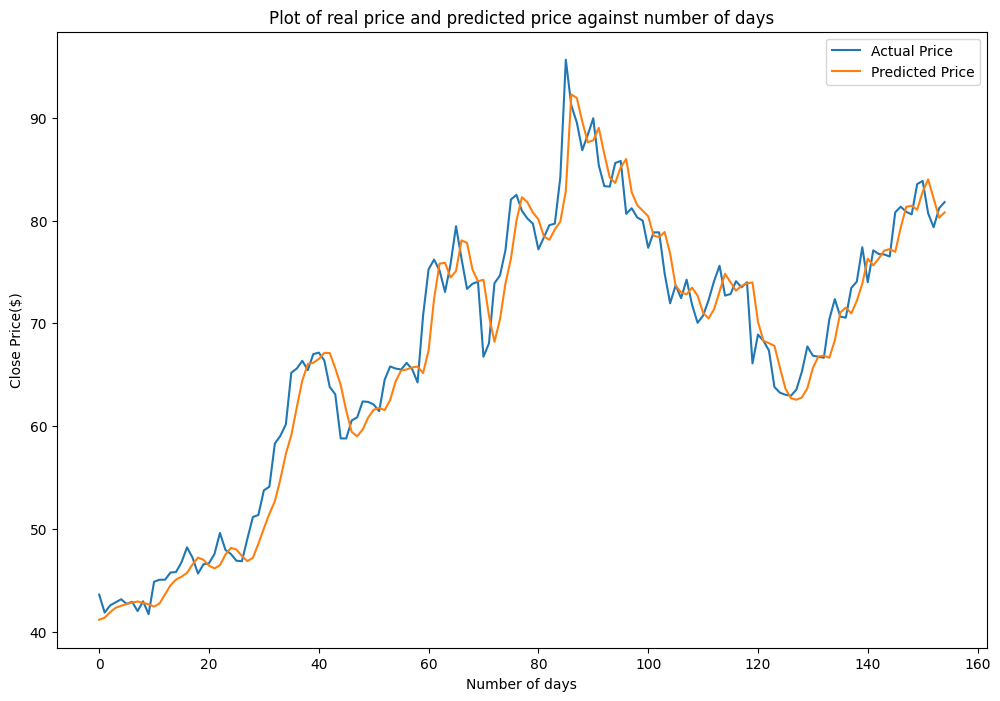

In [22]:
real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(preds, label='Predicted Price')

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Close Price($)')

plt.legend(['Actual Price', 'Predicted Price'])
plt.show()    